# Lung Cancer Detection using Convolutional Neural Network (CNN)

In [40]:
# import library
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Enable mixed precision for better GPU performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')

print("Libraries imported successfully!")


Libraries imported successfully!


In [8]:
# set parameter and define path of dataset

# Image processing parameters
IMG_SIZE = 64  # Reduced to save memory
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 16

# Define dataset path
data_path = r"E:\Machine Learning\lung cancer\lung_colon_image_set"

# Folders containing class images
category_folders = ["colon_image_sets", "lung_image_sets"]

print(" Parameters set successfully!")

 Parameters set successfully!


In [9]:
# get class name and subfolder 

classes = []

# Get all class names (subfolders inside category_folders)
for category in category_folders:
    category_path = os.path.join(data_path, category)
    subfolders = sorted([d for d in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, d))])
    classes.extend([(os.path.join(category_path, subfolder), subfolder) for subfolder in subfolders])

class_names = [cls[1] for cls in classes]
print("Classes found:", class_names)


Classes found: ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [10]:
# load and preprocess image

X, Y = [], []

for i, (class_path, class_name) in enumerate(classes):
    image_files = glob(os.path.join(class_path, "*.jpeg")) + \
                  glob(os.path.join(class_path, "*.jpg")) + \
                  glob(os.path.join(class_path, "*.png"))

    for image in image_files:
        img = cv2.imread(image)
        if img is None:
            print(f"⚠ Warning: Could not load image {image}")
            continue  

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        Y.append(i)

# Convert lists to numpy arrays
X = np.array(X, dtype=np.float16) / 255.0  # Normalize images
Y = pd.get_dummies(Y).values  # One-hot encode labels

# Ensure dataset is not empty
if len(X) == 0:
    raise ValueError("No images found! Check the dataset path.")

print(f"Loaded {len(X)} images from dataset.")


Loaded 25000 images from dataset.


In [11]:
# train test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=SPLIT, random_state=2022)

print(f" Dataset split into: {X_train.shape[0]} train samples, {X_val.shape[0]} validation samples")


 Dataset split into: 20000 train samples, 5000 validation samples


In [12]:
# define CNN model
model = keras.models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(len(class_names), activation='softmax', dtype='float32')  # Prevents precision issues
])

model.summary()
print("Model defined successfully!")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

In [13]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully")


Model compiled successfully


In [14]:
# Define Callbacks (Early Stopping & Learning Rate Adjustment)
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print("\n Validation accuracy reached 90%, stopping training!")
            self.model.stop_training = True

es = keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

print("Callbacks defined successfully")


Callbacks defined successfully


In [15]:
# train the model
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])

print("Model training completed")


Epoch 1/10
1250/1250 [==============================] - 19s 10ms/step - loss: 0.4968 - accuracy: 0.7999 - val_loss: 4.8721 - val_accuracy: 0.3248 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 12s 9ms/step - loss: 0.3558 - accuracy: 0.8608 - val_loss: 1.2382 - val_accuracy: 0.6654 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 12s 9ms/step - loss: 0.3101 - accuracy: 0.8781 - val_loss: 0.8670 - val_accuracy: 0.7510 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2627 - accuracy: 0.9020 - val_loss: 11.2776 - val_accuracy: 0.3934 - lr: 0.0010
Epoch 5/10
1247/1250 [============================>.] - ETA: 0s - loss: 0.2393 - accuracy: 0.9094
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 [==============================] - 12s 9ms/step - loss: 0.2394 - accuracy: 0.9094 - val_loss: 1.3601 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 6/10
1250/1250 [=======================

In [23]:
# # Save the Trained Model
# model_save_path = r"E:\Machine Learning\lung cancer\lung_cancer_model.h5"
# model.save(model_save_path)

# print(f"\n Model saved successfully at: {model_save_path}")


In [19]:
import os

model_dir = r"E:\Machine Learning\lung cancer\lung_cancer_model"
print(os.listdir(model_dir))


['assets', 'keras_metadata.pb', 'saved_model.pb', 'variables']


In [21]:
# Save in TensorFlow's native format
model.save(r"E:\Machine Learning\lung cancer\lung_cancer_model")


INFO:tensorflow:Assets written to: E:\Machine Learning\lung cancer\lung_cancer_model\assets


INFO:tensorflow:Assets written to: E:\Machine Learning\lung cancer\lung_cancer_model\assets


<Figure size 800x500 with 0 Axes>

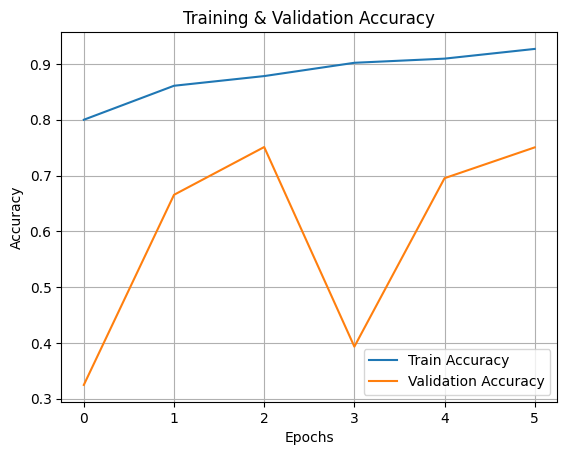

Training history plotted successfully!


In [24]:
# Plot Training & Validation Accuracy
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(8, 5))
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.grid()
plt.show()

print("Training history plotted successfully!")



In [42]:
# model evaluation
Y_pred = model.predict(X_val)
Y_val_classes = np.argmax(Y_val, axis=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Print Classification Report
print("\n Model Evaluation Report:")
print(metrics.classification_report(Y_val_classes, Y_pred_classes, target_names=class_names, zero_division=1))


157/157 [==============================] - 1s 4ms/step

 Model Evaluation Report:
                              precision    recall  f1-score   support

         Lung Adenocarcinoma       0.49      0.98      0.65       967
Lung Squamous Cell Carcinoma       1.00      0.00      0.00      1019
                 Normal Lung       0.95      0.85      0.90      1010
        Colon Adenocarcinoma       0.92      1.00      0.96       999
                Normal Colon       0.89      0.95      0.92      1005

                    accuracy                           0.75      5000
                   macro avg       0.85      0.75      0.68      5000
                weighted avg       0.85      0.75      0.68      5000



In [44]:
import numpy as np
import cv2
import tensorflow as tf

# Load the trained model (SavedModel format)
model_path = r"E:\Machine Learning\lung cancer\lung_cancer_model"
model = tf.keras.models.load_model(model_path)

# Updated class names (5 categories)
class_names = [
    "Lung Adenocarcinoma", 
    "Lung Squamous Cell Carcinoma", 
    "Normal Lung",
    "Colon Adenocarcinoma",
    "Normal Colon"
]

# Define a function for image preprocessing (to ensure consistent input shape)
def preprocess_image(image_path, img_size=64):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Error: Could not load the image at {image_path}. Check the file path.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype(np.float32) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load and preprocess the image
image_path = r"E:\Machine Learning\lung cancer\lungn.jpeg"
img = preprocess_image(image_path)

# Use @tf.function to avoid retracing issues
@tf.function(reduce_retracing=True)
def make_prediction(model, img):
    return model(img, training=False)

# Make prediction
predictions = make_prediction(model, img)

# Debugging: Print raw predictions
print("Raw Model Predictions:", predictions.numpy())  # Convert tensor to NumPy
print("Shape of Predictions:", predictions.shape)

# Ensure output matches class count
if predictions.shape[1] == len(class_names):
    predicted_class = np.argmax(predictions.numpy())
    print(f"Predicted Class: {class_names[predicted_class]}")
else:
    print("Error: Model output does not match class names count! Update class_n")


Raw Model Predictions: [[9.4892890e-08 5.7246239e-09 1.1138915e-05 9.9998844e-01 3.2817960e-07]]
Shape of Predictions: (1, 5)
Predicted Class: Colon Adenocarcinoma
